In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [12]:
# 构建数据集
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])

train_data = datasets.MNIST(root='../dataset/mnist',
                            download=False,
                            train=True,
                            transform=transform)

test_data = datasets.MNIST(root='../dataset/mnist',
                            download=False,
                            train=False,
                            transform=transform)

train_loader = DataLoader(dataset=train_data,
                          shuffle=True,
                          batch_size=batch_size)

test_loader = DataLoader(dataset=test_data,
                          shuffle=False,
                          batch_size=batch_size)

In [ ]:
# 创建模型
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear = torch.nn.Linear(320,10)
        self.Conv1 = torch.nn.Conv2d(1,10,kernel_size=5)
        self.Conv2 = torch.nn.Conv2d(10,20,kernel_size=5)
        self.Pool1 = torch.nn.MaxPool2d(2)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.Pool1(self.Conv1(x)))
        x = F.relu(self.Pool1(self.Conv2(x)))
        x = x.view(batch_size, -1)
        x = self.linear(x)
        return x
    
model  =Net()

In [14]:
# 迁移到GPU上训练
device = torch.device("cuda:0")
model.to(device)

Net(
  (linear): Linear(in_features=320, out_features=10, bias=True)
  (Conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (Conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (Pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [15]:
# 构建损失和优化器
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [16]:
# 训练函数
def train(epoch):
    running_loss = 0
    for index, data in enumerate(train_loader, 0):
        input, target = data

        input, target = input.to(device), target.to(device)

        y_pred = model(input)            # 前馈
        loss = criterion(y_pred, target) # 计算损失

        running_loss += loss.item()

        optimiser.zero_grad()            # 清空梯度
        loss.backward()                  # 反向传播
        optimiser.step()                 # 更新参数
        
        if (index+1)%100 == 0:
            print(f"[{epoch+1}-{index+1}] - Loss:{running_loss/100:.4f}")
            running_loss = 0

In [17]:
# 测试函数
def test():
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            input, target = data

            input, target = input.to(device), target.to(device)

            y = model(input)
            _,y_pred = torch.max(y.data,dim=1)
            correct += (y_pred == target).sum().item()
            total += input.size(0)
    print(f"准确率: {correct/total:.4f}")
    return correct/total


In [18]:
# 主函数
list = []
for epoch in range(5):
    train(epoch)
    list.append(test())
# 在训练循环结束后保存模型
torch.save(model.state_dict(), 'mnist_model.pth')

[1-100] - Loss:1.3226
[1-200] - Loss:0.4084
[1-300] - Loss:0.3053
[1-400] - Loss:0.2552
[1-500] - Loss:0.1978
[1-600] - Loss:0.1922
[1-700] - Loss:0.1516
[1-800] - Loss:0.1447
[1-900] - Loss:0.1374
准确率: 0.9647
[2-100] - Loss:0.1196
[2-200] - Loss:0.1118
[2-300] - Loss:0.1140
[2-400] - Loss:0.1260
[2-500] - Loss:0.1047
[2-600] - Loss:0.1078
[2-700] - Loss:0.0949
[2-800] - Loss:0.0965
[2-900] - Loss:0.0894
准确率: 0.9763
[3-100] - Loss:0.0833
[3-200] - Loss:0.0837
[3-300] - Loss:0.0885
[3-400] - Loss:0.0776
[3-500] - Loss:0.0894
[3-600] - Loss:0.0790
[3-700] - Loss:0.0729
[3-800] - Loss:0.0676
[3-900] - Loss:0.0734
准确率: 0.9762
[4-100] - Loss:0.0637
[4-200] - Loss:0.0645
[4-300] - Loss:0.0637
[4-400] - Loss:0.0698
[4-500] - Loss:0.0717
[4-600] - Loss:0.0683
[4-700] - Loss:0.0693
[4-800] - Loss:0.0686
[4-900] - Loss:0.0631
准确率: 0.9808
[5-100] - Loss:0.0548
[5-200] - Loss:0.0555
[5-300] - Loss:0.0550
[5-400] - Loss:0.0684
[5-500] - Loss:0.0676
[5-600] - Loss:0.0560
[5-700] - Loss:0.0574
[5-800

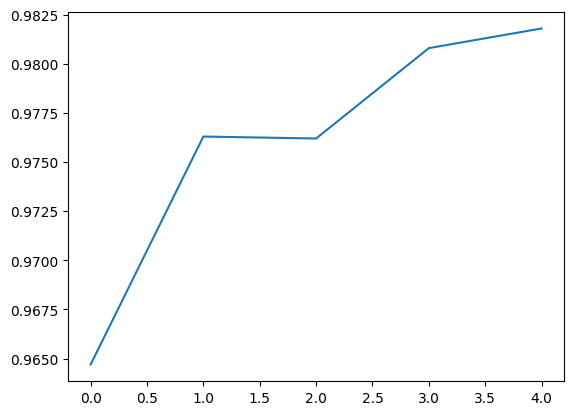

In [19]:
plt.plot(list)